## IBM Q X 14-qubit device:
### Scalable characterization of all local-averaged Pauli error rates

© Robin Harper 2016-2020

Best viewed with the nbextensions, Collapsible Headings enabled.

<span style="color:blue">
The purpose of this notebook is to analyze data from the IBM 14-qubit quantum device (Melbourne) taken using the scalable noise reconstruction protocol for estimating averaged Pauli error rates. The full protocol for estimating all of the Pauli error rates requires the ability to generate a 14-qubit Clifford gate, and this is too ambitious for this device. Therefore, we focus on the simpler task of estimating the _symmetrized_ error rates, where we twirl with $n$ copies of the single-qubit Clifford group/twin-qubit Clifford group instead of the Pauli group. </span>

    
In this worksheet we will use bootstrapping to give error bars.


**Note:** 
  -   the bootstrapping cells are quite time-intenstive 30 mins ~ 1 hour, so they have been disabled and previously generated results are loaded in.
  -   graph saving commands have been commented out, so previously generated graphs are not over-written.
  -   even on a desktop the reading and processing of the bootstrapped files (for error bars) can take quite a few minutes each.
  
-----------------

## For the two qubit protocol use the workbook TwoQubitGates

------------------

© Robin Harper 2015-2020, All rights reserved

# Load in the software we are using


1. We use a few standard Julia packages, which will need to be added if you don't have them.

 - LsqFit
 - Hadamard
 - PyPlot
 - ProgressMeter

2. Define a couple of convenience functions.


In [1]:
using LsqFit
using Hadamard
using PyPlot
using ProgressMeter
using Juqst
# convenience (type /otimes<tab>)
⊗ = kron

┌ Info: Installing pyqt package to avoid buggy tkagg backend.
└ @ PyPlot /Users/robin/.julia/packages/PyPlot/4wzW1/src/init.jl:118
┌ Info: Installing PyQt5 via the Conda pyqt package...
└ @ PyCall /Users/robin/.julia/packages/PyCall/kAhnQ/src/PyCall.jl:697
┌ Info: Running `conda install -y pyqt` in root environment
└ @ Conda /Users/robin/.julia/packages/Conda/3rPhK/src/Conda.jl:113
Traceback (most recent call last):
  File "/Users/robin/.julia/conda/3/bin/conda", line 12, in <module>
    from conda.cli import main
ModuleNotFoundError: No module named 'conda'


kron (generic function with 34 methods)

In [2]:
# A lot of the drawing stuff is particular to th  14 qubit machine
# and is in a seperate file
include("marginalDrawing.jl")

covhinton

In [3]:
# The fitting model, for use with LsqFit.
modelF(x, p) = p[1]*(p[2].^x)

modelF (generic function with 1 method)

In [4]:
""" 
convenience function to extract the ends of a vector.
Used with bootstrap, i.e. calcuate a function based on the boostrapped data and return the values
corresponding to σ deviations.
Assumes the vector is already sorted.
"""
function extractEnds(sorted;low=159,high=841) # default is single sigma
    return (sorted[low],sorted[high])
end


extractEnds

# Load in the single qubit twirl data

 - read in the files
 - transform and fit, extracting the fit parameter into params
 
 We have 
 - singleParams - which will equal the Clifford eigenvalues
 - singlePs - which represents the global SPAM free probabilities (possibly with small negative values)
 - singlePps - which reprepesnts singlePs, projected onto the nearest probability simplex.




In [5]:
# Read in the raw results stored on a per sequence length
# Binary valued so first entry = 0000000000000000
# Then a 1 on qubit 0 is the second entry i.e. 0000000000000001
# all the way to a 1 on all qubits 111111111111111111111111
using DelimitedFiles
# The re-run of single qubit had a longer tail.
singleLengths=vcat([1,5,10,15,20],collect(30:15:110));
fullMatrixS = readdlm("./data/results14Single_1_5_10_15_20_30_45_60_75_90_105.csv",',',Int64);
fullMatrixS

11×16384 Array{Int64,2}:
 245907  19419  40044  3266  17493  …  0  0  0  0  0  0  0  0  0  0  0  0
 166135  14639  41640  3938  18589     0  0  0  0  0  0  0  0  0  0  0  0
 105754  11295  34588  3940  18449     0  0  0  0  0  0  0  0  0  0  0  0
  70648   8601  29350  3819  14953     0  0  0  0  0  0  0  0  0  0  0  0
  48405   6642  23358  3272  13303     0  0  0  0  0  0  0  0  0  0  0  0
  24206   3899  15497  2641   8901  …  0  0  0  0  0  0  0  0  0  0  0  0
   9715   2050   7606  1718   5196     1  0  0  0  0  0  0  0  0  0  0  0
   4933   1346   4289  1191   2991     2  0  0  2  0  0  0  0  0  0  0  0
   2727    837   2535   795   2020     1  0  1  1  1  2  1  2  0  0  1  0
   1687    617   1685   623   1385     4  1  3  1  2  1  0  2  1  1  1  0
   1132    476   1174   441   1024  …  5  3  2  3  3  1  4  1  1  0  0  2

In [6]:
# Approximately 1 million shots (1000*1024)
sum(fullMatrixS[2,:])

1024000

In [7]:
# Split it up into different arrays all the runs of a particular length, altered to a probability.
splitMatrixS=[fullMatrixS[i,:]/sum(fullMatrixS[i,:]) for i in 1:11];

In [8]:
params, dataL  = fitTheFidelities(singleLengths,splitMatrixS);
singleParams = params;

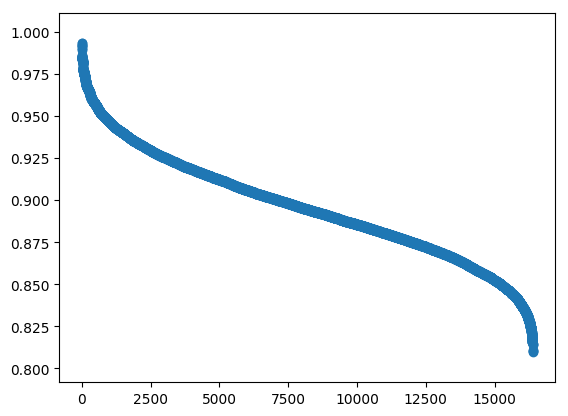

PyObject <matplotlib.collections.PathCollection object at 0x7ffa18baa5c0>

In [9]:
# We can plot all the fidelities...
scatter(1:length(singleParams),reverse(sort(map(x->x[2],singleParams))))

In [10]:
## The global probability vector is now the hadamard transform of the parameters
## And we project it down onto an actual probability simplex.

singlePs =  fwht_natural(vcat([1],map(x->x[2],singleParams)))
singlePps = projectSimplex(singlePs);

# Create the Bootstrapped data


We will have 

- thousandParams: the Clifford eigenvalues for 1,000 sets of bootstrapped data.
- thousandSPps: the projected global probability estimates for 1,000 sets of bootstrapped data.


### To bootstrap turn original observed probabilities into a cumulative sum and then recreate by rolling dice.

In [11]:
function bootStrappedMatrices(size,shots,cumulativeMatrix)
    toRet = []
    for todo = 1:length(cumulativeMatrix)
        counted = zeros(size)
        rolls = rand(shots)
        for i in rolls
            #using the fact that the cululativeMatrix is (effectively) sorted.
            counted[searchsortedfirst(cumulativeMatrix[todo],i,)] +=1
        end
        push!(toRet,counted./shots)
    end
    return toRet
end

bootStrappedMatrices (generic function with 1 method)

### Now we generate the bootstrapped data

- We don't save all the data, (it would take up a lot of memory)
- But we fit each of the 1000 (giving us 1,000 2^14 vectors) and keep them and their hadamard transform in memory.

In [12]:
# ### About 30 mins worth of code, saved
# _size = 2^14
# shots = sum(fullMatrixS[1,:])
# culmMatrixX = map(cumsum,splitMatrixS)
# p=Progress(1000)
# thousandSPps=[]
# thousandParams=[]
# for i in 1:1000
#     bsm=bootStrappedMatrices(_size,shots,culmMatrixX)
#     bsp,_ = getParamsWithCutoff(singleLengths,bsm,no=i);
#     push!(thousandParams,bsp)
#     singlebsPs =  fwht_natural(vcat([1],map(x->x[2],bsp)))
#     singlebsPps = Marginal.projectSimplex(singlebsPs);
#     push!(thousandSPps,singlebsPps)
#     next!(p)
# end

In [13]:
### Because of the way it was saved we need to translate the 'thousandParam' style of things.
function translateThousandCSV(temp)
    # The param lists saved as e.g. "[0.859164"  " 0.993246]" , so just filter out non-number stuff and parse.
    return [[[
                parse(Float64,filter(x->isdigit(x) || x=='.',temp[ix,i])),
                parse(Float64,filter(x->isdigit(x) || x=='.',temp[ix,i+1]))] 
                        for i = 1:2:length(temp[ix,:])] 
                                                                for ix = 1:size(temp)[1]]
end


translateThousandCSV (generic function with 1 method)

In [14]:
## This takes a minute or two on my computer - don't panic

#writedlm("savedAnalysis/ThousandSingleParams.csv",thousandParams,',')
#writedlm("savedAnalysis/ThousandSinglePps.csv",thousandSPps,',')

thousandParams = translateThousandCSV(readdlm("./savedAnalysis/ThousandSingleParams.csv",','))
thousandSPps = readdlm("./savedAnalysis/ThousandSinglePps.csv",',')
# array -> list of lists.
thousandSPps = [thousandSPps[i,:] for i in 1:size(thousandSPps)[1]];

In [15]:
@assert(size(thousandParams)[1] == 1000)

In [16]:
# And just to check, quick peek at the first one.
thousandParams[1]

16383-element Array{Array{Float64,1},1}:
 [0.859591, 0.993224] 
 [0.72803, 0.958708]  
 [0.628172, 0.953354] 
 [0.872474, 0.976415] 
 [0.752715, 0.970206] 
 [0.65136, 0.938273]  
 [0.560129, 0.933017] 
 [0.525977, 0.991467] 
 [0.451547, 0.984836] 
 [0.38461, 0.950127]  
 [0.331078, 0.944964] 
 [0.459325, 0.968555] 
 [0.396221, 0.962191] 
 ⋮                    
 [0.170526, 0.851759] 
 [0.146468, 0.846047] 
 [0.131139, 0.813104] 
 [0.113283, 0.805816] 
 [0.102363, 0.858383] 
 [0.0870657, 0.852226]
 [0.0764872, 0.821088]
 [0.0672595, 0.810303]
 [0.0883567, 0.846987]
 [0.0758053, 0.84139] 
 [0.0683717, 0.812153]
 [0.058747, 0.808615] 

# Mutual Information plots


Used in Figure 2

- Generates the Mutual Information between each of the qubits.
- Then does this again for each of the boostrapped versions.

Draws them using a Hinton Plot, set out as per IBM layout

In [17]:
mutualPsSingle = [[mutualInformation(q,i,singlePps) for q in 1:14] for i in 1:14]

## For each of the boostrapped distributions, calculate the Mutual Information between each of the qubits.

allMI = []
p=Progress(1000)
for x in thousandSPps
    push!(allMI,[[mutualInformation(q,i,x) for q in 1:14] for i in 1:14]);
    next!(p)
end



Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [18]:
# Extract the high/low for each particular cell using the boostrap data
boostrapMI=[[extractEnds(sort(map(x->x[a][b],allMI)),low=159,high=841) for b=1:14] for a=1:14];

### We are now going to draw some things. 

A lot of the visualisation is quite particular to the layout of the 14 qubit machine.


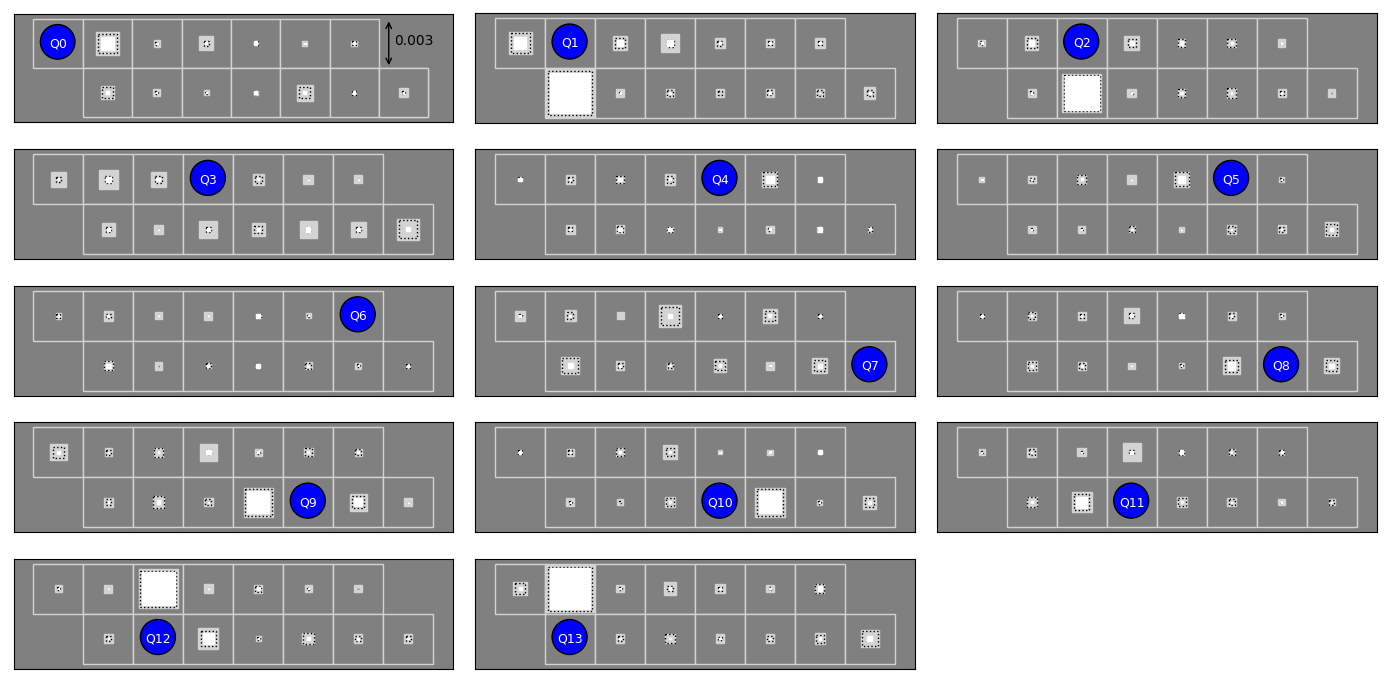

In [19]:
## Draw the hinton diagrams showing the mutual information between qubits
## We pass in the apprpriate values to create error bars.
## translate_14Q_Locations just puts the qubits in the correct place for the Melbourne device.

fig = figure("Qubits Single Sigma",figsize=(14,7))
for i =1:14
    subplot(5,3,i)
    hinton(translate_14Q_Location(mutualPsSingle[i]',1),
        0.003,gca(),
        errorsH=translate_14Q_Location(map(x->x[2],boostrapMI[i])',1),
        errorsL=translate_14Q_Location(map(x->x[1],boostrapMI[i])',1),
        highlightNegative=true,fontsize=9,qubitPairs=[],addScale=i==1)
end
plt.tight_layout()


# Correlation Matrices



Used in Figure 2.

- corrmatSingle: the 14x14 correlation matrix using the projected global probability
- corrmatsSingle: the 14x14 correlation matrices for each of the bootstrapped probabilities.

In [20]:
corrmatSingle = correlationMatrix(singlePps);
corrmatsSingle = [correlationMatrix(x) for x in thousandSPps];


In [21]:
# For each cell in the correlation matrix, choose the high and low bootstrapped values (at the approp. sigma bounds)
highCorrSingle = [extractEnds(sort(map(x->x[b,a],corrmatsSingle)),low=159,high=841)[2] for a in 1:14, b in 1:14]
lowCorrSingle =  [extractEnds(sort(map(x->x[b,a],corrmatsSingle)),low=159,high=841)[1] for a in 1:14, b in 1:14];

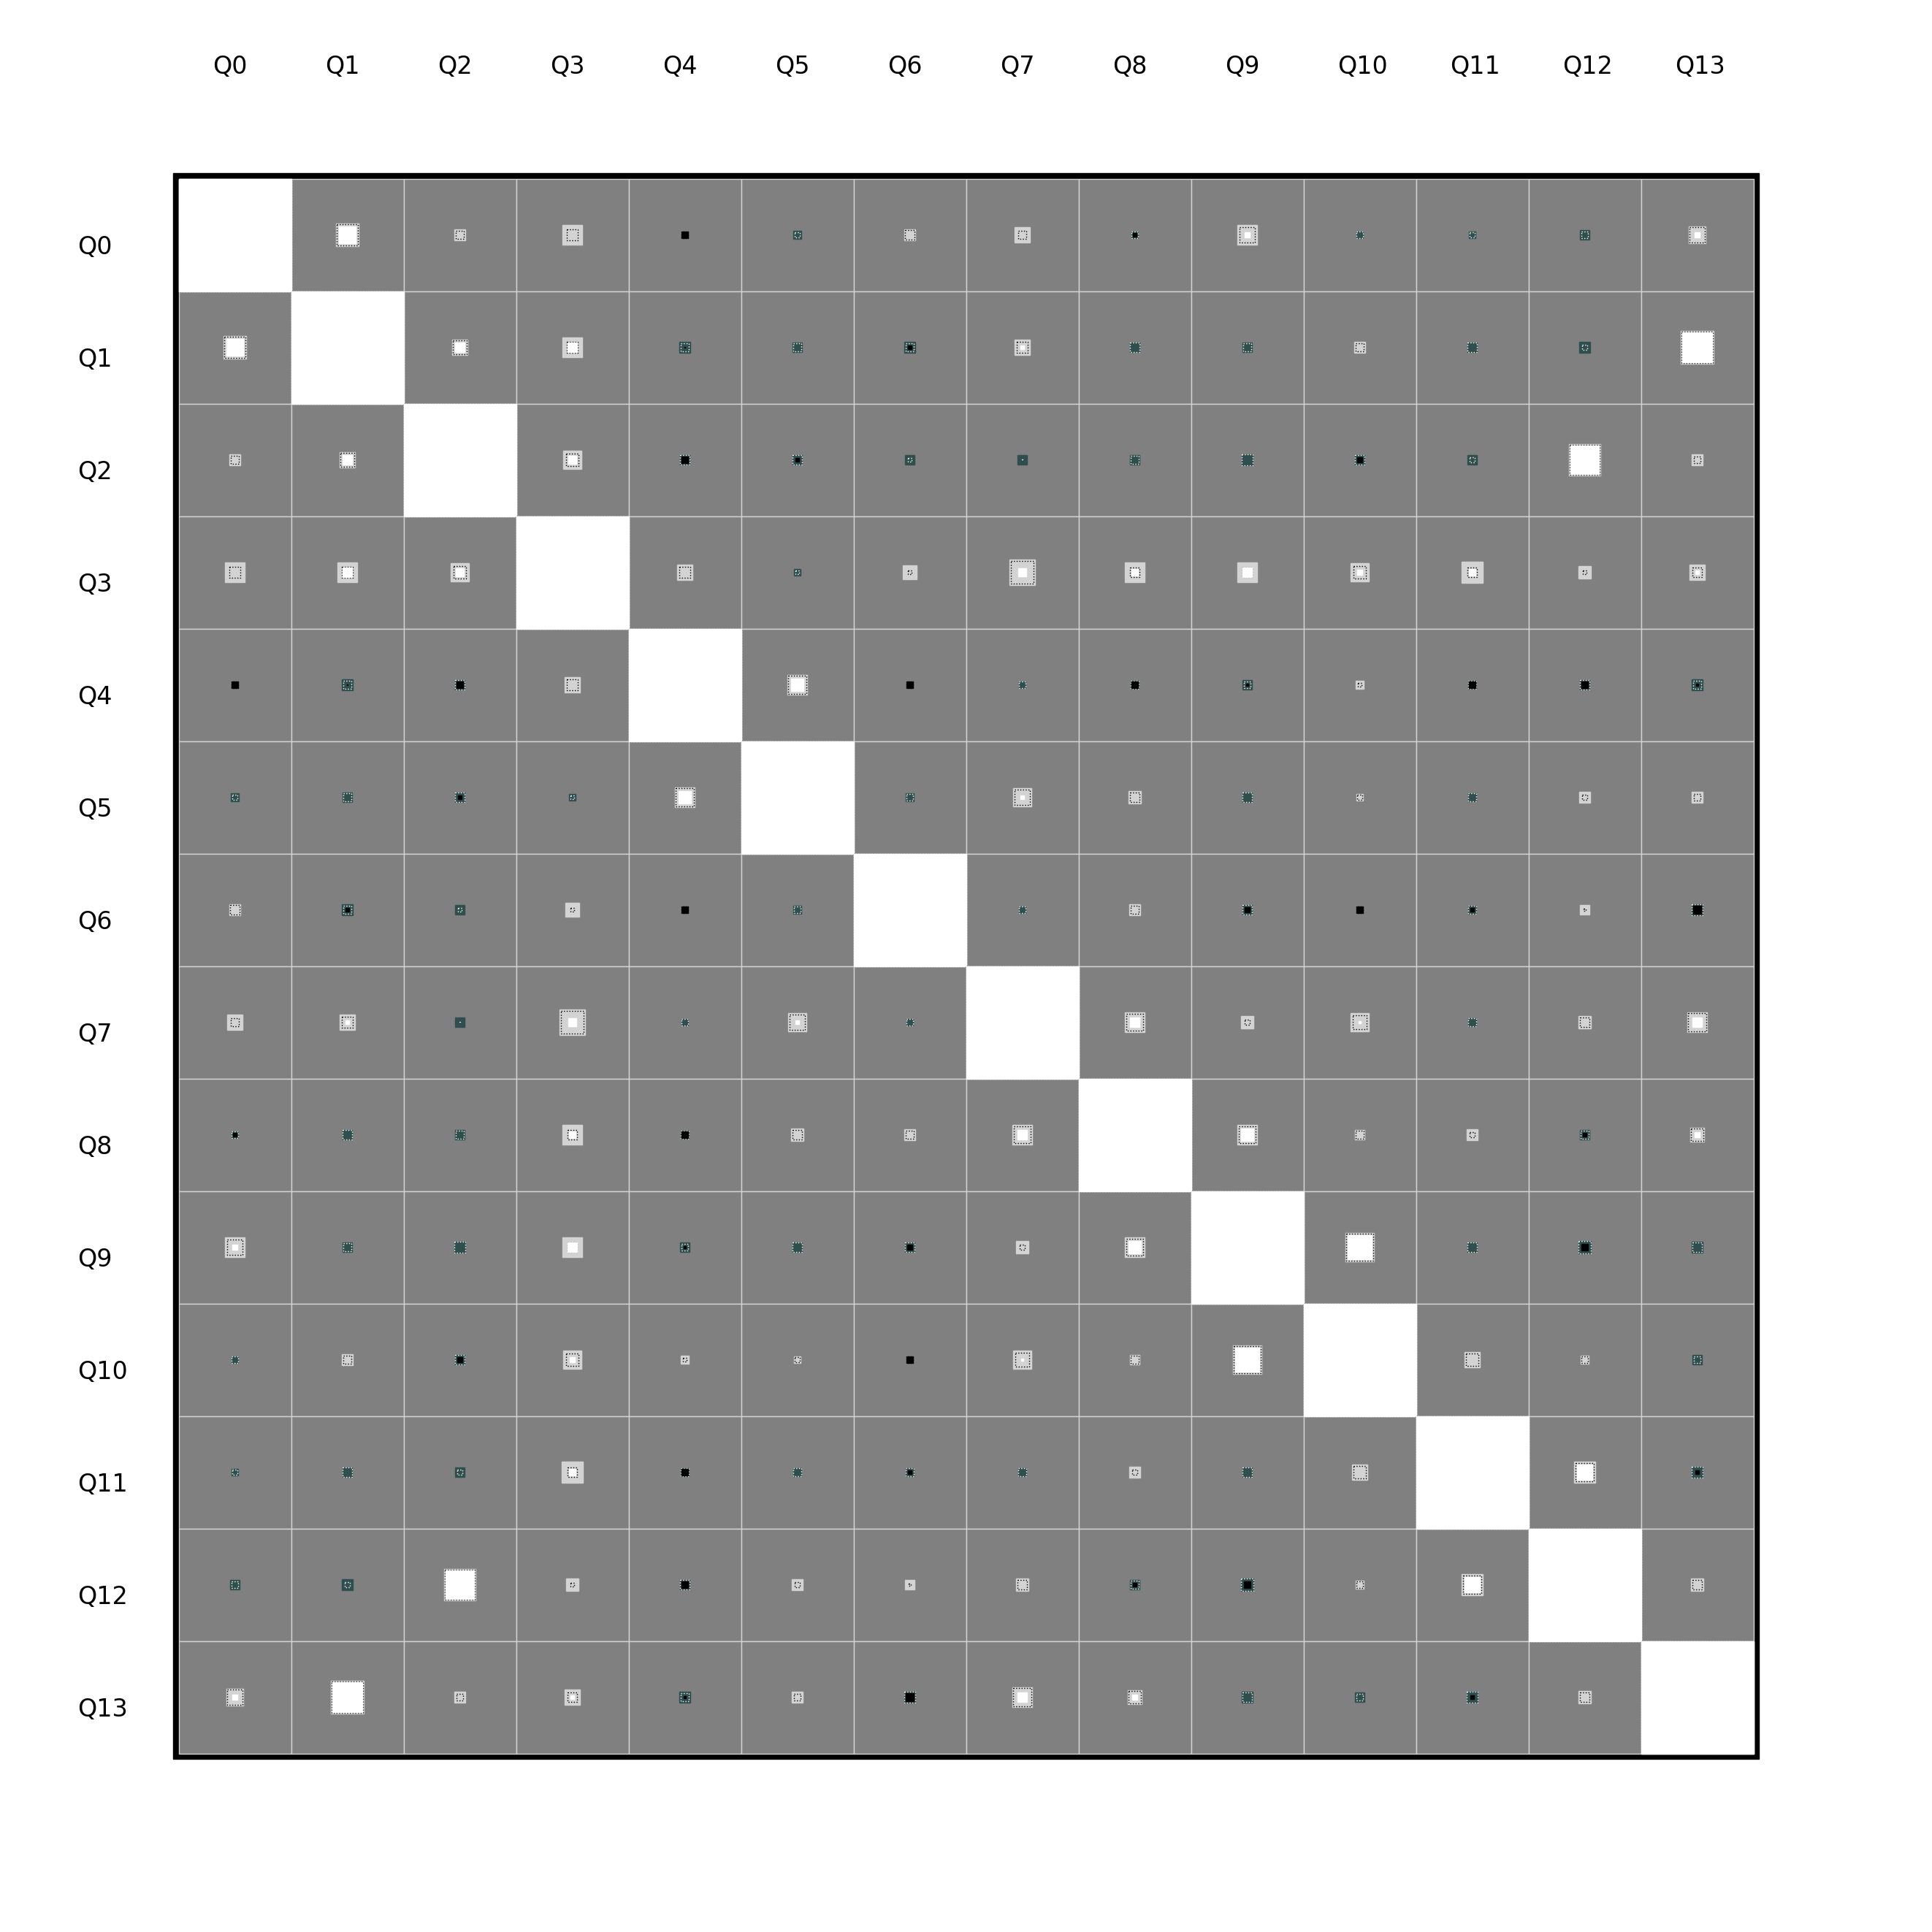

In [22]:
## This is a conventional hinton plot
# Large figure size gives us a crisp plot
fig = figure("Slightly larger",figsize=(34,34))

covhinton(corrmatSingle,1,gca(),
    highCorr = highCorrSingle,
    lowCorr =  lowCorrSingle,
    addScale=false,addAxis=true,adjust=0.8,addOneAxis=true,showQubits=false,fontsize=24,stagger=false)


#PyPlot.savefig("./SavedPDFs/OnequbitCorr_1Sigma.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/OnequbitCorr_1Sigma.png", bbox_inches = "tight", pad_inches = 0)

# Generate the GRF using global probabilities



This is based on the following 'ansatz'

![grf](./grf.png)

Where qubits have been renumbered to account for Julia prefering 1-indexing.

Used: 
- to construct JSD numbers in paper.
- Figure 2
- Figure 5 (supplement)

Creates:
- ϕ the joint probabilities for the Gibbs field.
- reconstructed, the reconstructed global probability distrubtion using ϕ
- corrmatSingleGibbs: The correlation matrix using the reconstructed probability distribution
- corrmatsSingleGibbs: The correlation matrix using the reconstructip p.d. for bootstrap data.



## Calculate the JSD for the ansatz

In [23]:
# This is our 'ansatz' based on the resonators of the IBM
# This is the 'simplest' way to use the software, but it requires the constraints in a particular way
# Here we look at the overlap so [[1,2,14],[2,14]] - would mean p(1,2|2,14)p(2,14) etc.

constraints = [[1,2,14],[2,14,13,3],[13,3,4,12],[4,12,5,11],[5,11,6,10],[6,10,7,9],[7,9,8]]

7-element Array{Array{Int64,1},1}:
 [1, 2, 14]    
 [2, 14, 13, 3]
 [13, 3, 4, 12]
 [4, 12, 5, 11]
 [5, 11, 6, 10]
 [6, 10, 7, 9] 
 [7, 9, 8]     

### We can look at the Relative Entropy between our $\tilde{\,p}_1$ and the reconstructed p

$D_{KL}(P||Q) = \sum\limits_{j}p_j\log\frac{p_j}{q_j}$

But *note* this is not defined if $q_j$ is zero when $p_j$ is non-zero, and it is not symmetric.

Instead use... 

### Jensen Shannon divergence 

Jensen Shannon divergence is symmetric, always valid and if you take the square root (Jensen Shannon Distance) it is a metric.

$\text{JSD}(P||Q) = \frac{1}{2}D(P||M) + \frac{1}{2}D(Q||M), M = \frac{1}{2}(P+Q)$

In [24]:
# A different (more general) way of expressing the constraints is, lists of conditionals
# So here we write out p(1|2,14)p(2,14|13,3)p(13,3|4,12)p(4,12|5,11)p(6,10|7,9)p(7,9,8)
# as

generalisedConstraints =[
                            [[1,],[2,14]],
                            [[2,14],[13,3]],
                            [[13,3],[4,12]],
                            [[4,12],[5,11]],
                            [[5,11],[6,10]],
                            [[6,10],[7,9]],
                            [[7,9,8],[]]]

# Which is the same as the one above.

7-element Array{Array{Array{Any,1},1},1}:
 [[1], [2, 14]]    
 [[2, 14], [13, 3]]
 [[13, 3], [4, 12]]
 [[4, 12], [5, 11]]
 [[5, 11], [6, 10]]
 [[6, 10], [7, 9]] 
 [[7, 9, 8], []]   

In [25]:
ϕold = gibbsRandomField(singlePps,constraints) 
reconstructed_old = [getGrainedP(ϕold,tomatch,[vcat(x[1],x[2]) for x in generalisedConstraints]) for tomatch =0:(2^14-1)]
sqrt(JSD(singlePps,reconstructed_old))

0.04164373290220545

In [26]:
# Then we can fill in the joint probabilities:
ϕ=gibbsRandomField(singlePps,generalisedConstraints) 
# Reconstruct the entire probability distribution using our markov field.
reconstructed = [getGrainedP(ϕ,tomatch,[vcat(x[1],x[2]) for x in generalisedConstraints]) for tomatch =0:(2^14-1)]
# And check we get the same JSD as with the earlier version
sqrt(JSD(singlePps,reconstructed))

0.04164373290220545

## Do the same, but with all the bootstrap data to get error bars

In [27]:
# Takes a few minutes.
bootstrapJs = [reconstructedJS(x,constraints) for x in thousandSPps];
extractEnds(sort(bootstrapJs),low=27,high=977)

(0.001618195331556055, 0.0025259787865322425)

In [28]:
sqrt(JSD(singlePps,reconstructed))

0.04164373290220545

In [29]:
sqrt.(extractEnds(sort(bootstrapJs),low=27,high=977))

(0.040226798673969257, 0.05025911645196563)

## More bootstrapping

- Generate the GRF for each bootstrap data
- reconstruct the entire probability vector for each bootstrapped GRF

In [30]:
# This takes a bit of storage and a bit of work 3-4 mins
bootStrapReconstructedPPs = []
@showprogress for x in thousandSPps
    ϕ=gibbsRandomField(x,generalisedConstraints) 
    # Reconstruct the entire probability distribution using our markov field.
    push!(bootStrapReconstructedPPs,[getGrainedP(ϕ,tomatch,[vcat(x[1],x[2]) for x in generalisedConstraints]) for tomatch =0:(2^14-1)])
end



Progress: 100%|█████████████████████████████████████████| Time: 0:03:38


## Generate GRF correlations matrix (and all the bootstrapped ones.)

In [31]:

# This takes time.
corrmatsSingleGibbs = [correlationMatrix(x) for x in bootStrapReconstructedPPs];
corrmatSingleGibbs = correlationMatrix(reconstructed);


## Plot the GRF Correlation Matrix.

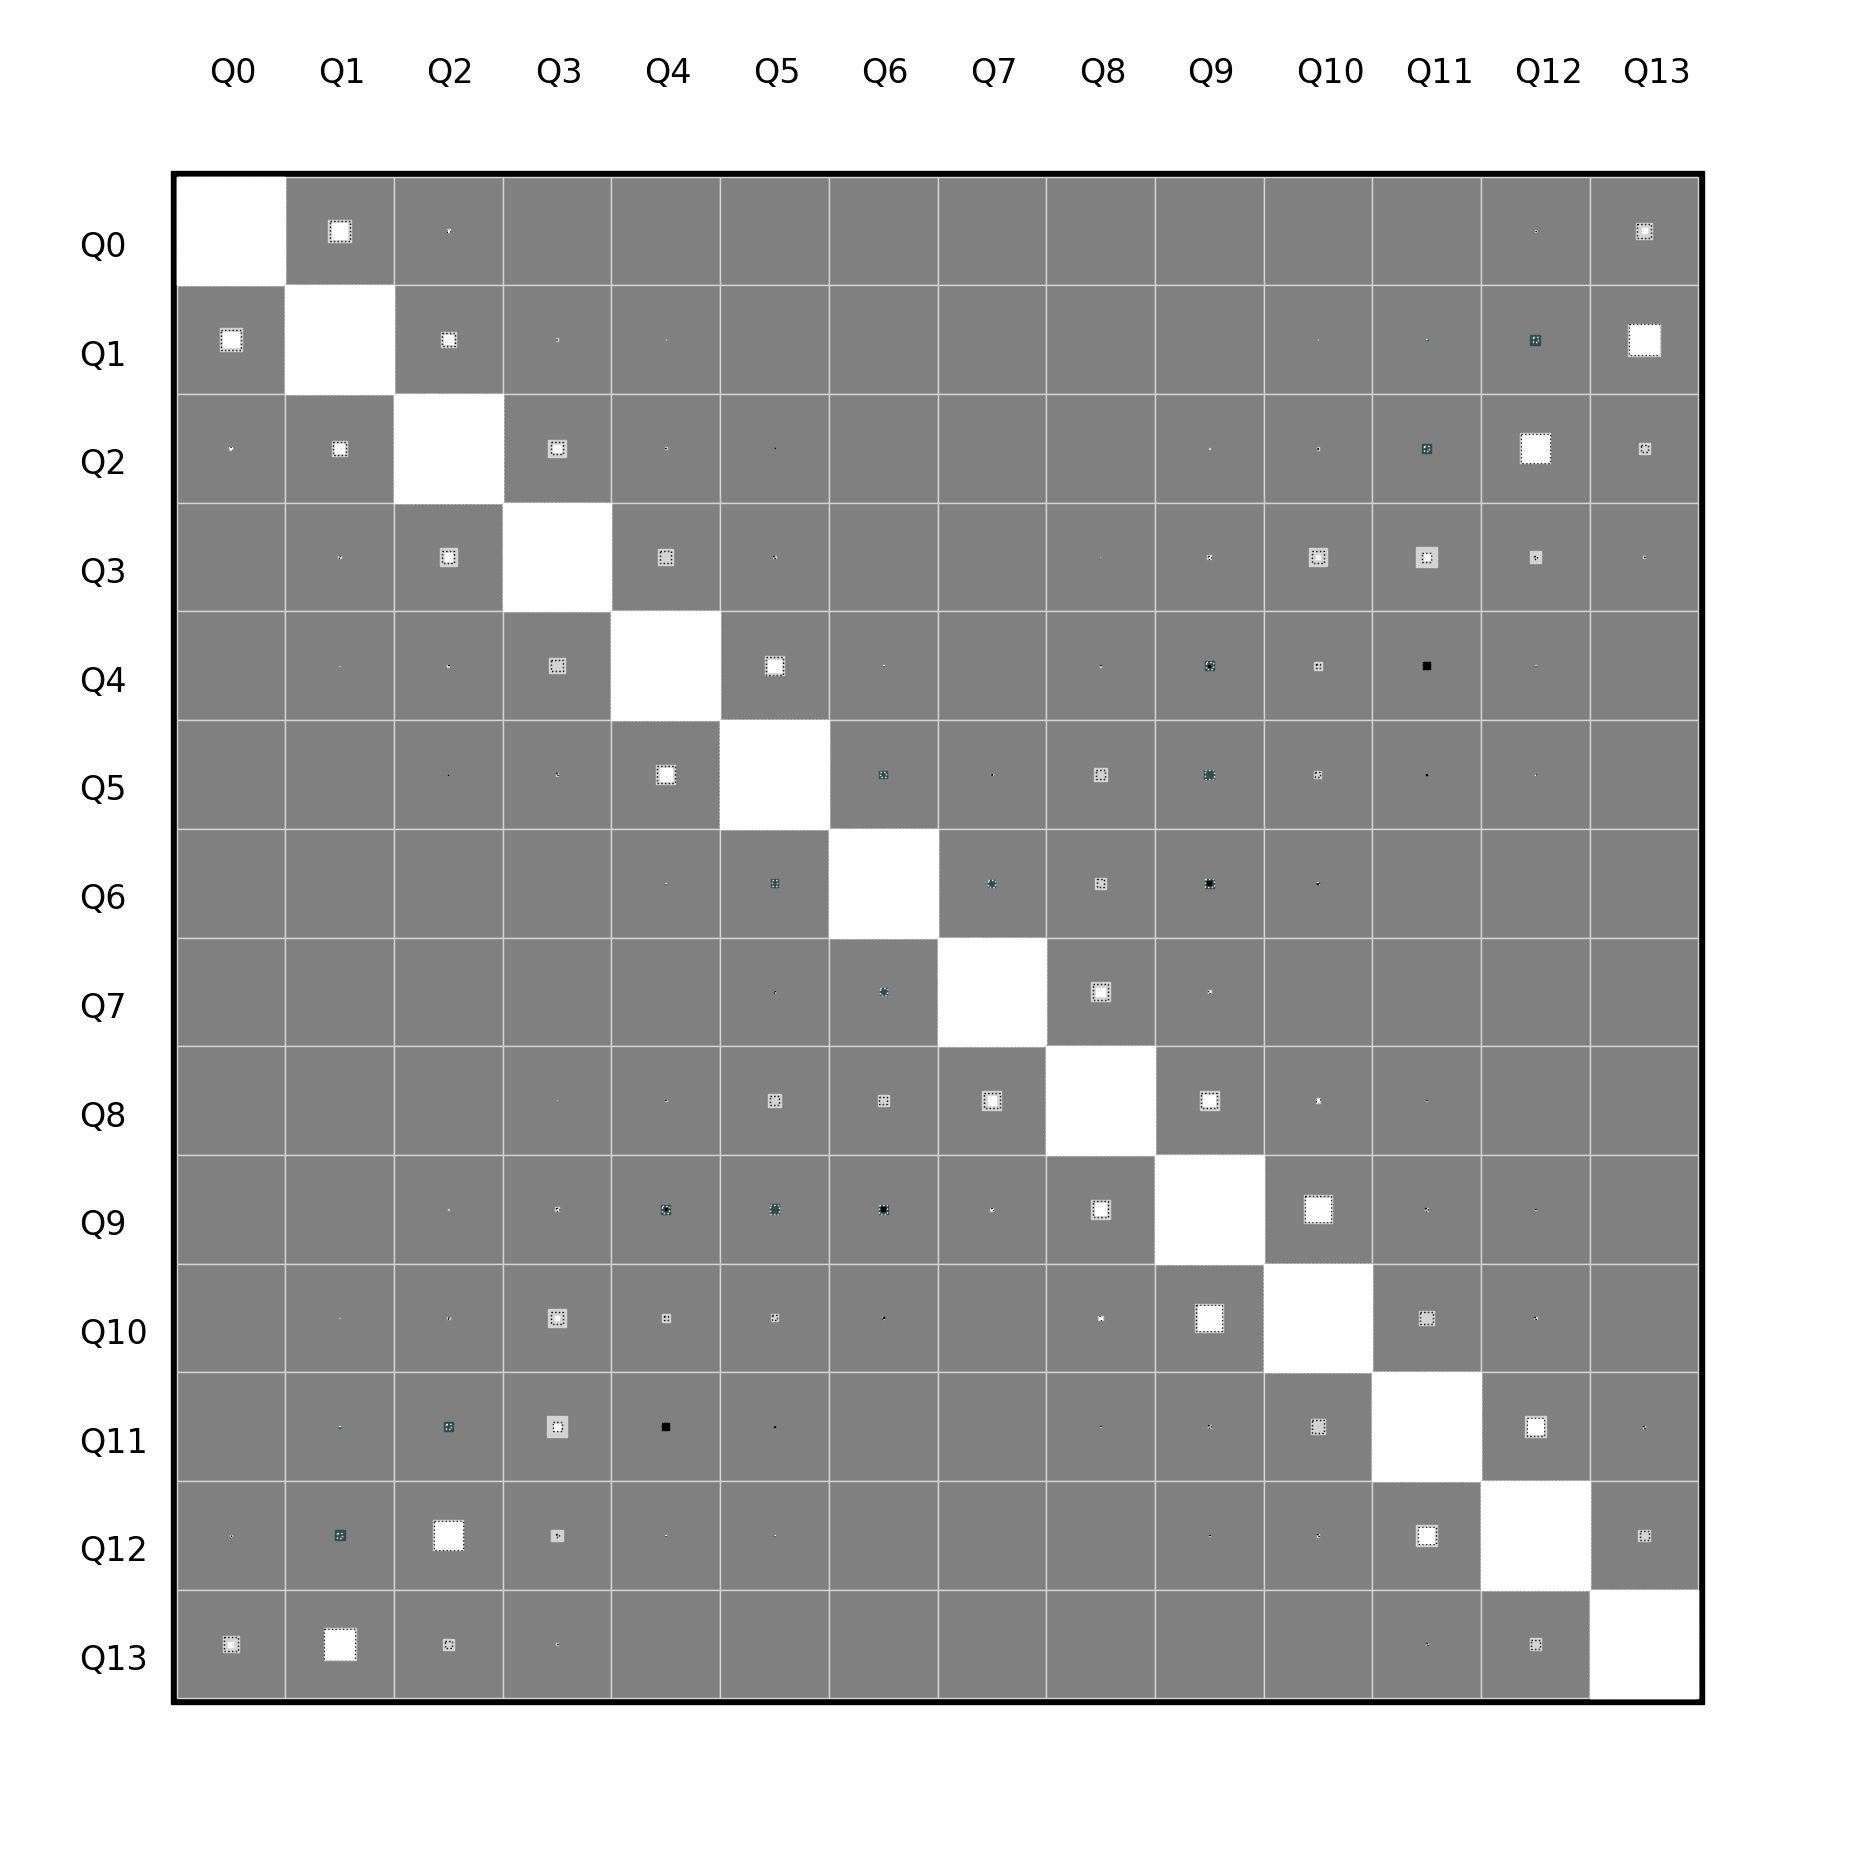

In [32]:
fig = figure("Slightly larger",figsize=(24,24))

highCorrSingleGibbs = [extractEnds(sort(map(x->x[b,a],corrmatsSingleGibbs)),low=159,high=841)[2] for a in 1:14, b in 1:14]
lowCorrSingleGibbs =  [extractEnds(sort(map(x->x[b,a],corrmatsSingleGibbs)),low=159,high=841)[1] for a in 1:14, b in 1:14];
fig = figure("Slightly larger",figsize=(12,12))

covhinton(corrmatSingleGibbs,1,gca(),
    highCorr = highCorrSingleGibbs,
    lowCorr =  lowCorrSingleGibbs,
    addScale=false,addAxis=true,adjust=0.8,addOneAxis=true,showQubits=false,fontsize=24,stagger=false)

#PyPlot.savefig("./SavedPDFs/gibbsSingleWithError.pdf", bbox_inches = "tight", pad_inches = 0)


## Reproduce the combined Plot shown in Figure 2

In [33]:
# To fully recreate the correlation matrix in Figure 2, we need to combine our previous charts.

corrmatCombined = copy(corrmatSingle)
corrmatCH = copy(highCorrSingle)
corrmatCL = copy(lowCorrSingle)
for j = 2:14
    for i = 1:j-1
        corrmatCombined[i,j] = corrmatSingleGibbs[i,j]
        corrmatCH[i,j] = highCorrSingleGibbs[i,j]
        corrmatCL[i,j] = lowCorrSingleGibbs[i,j]
    end
end

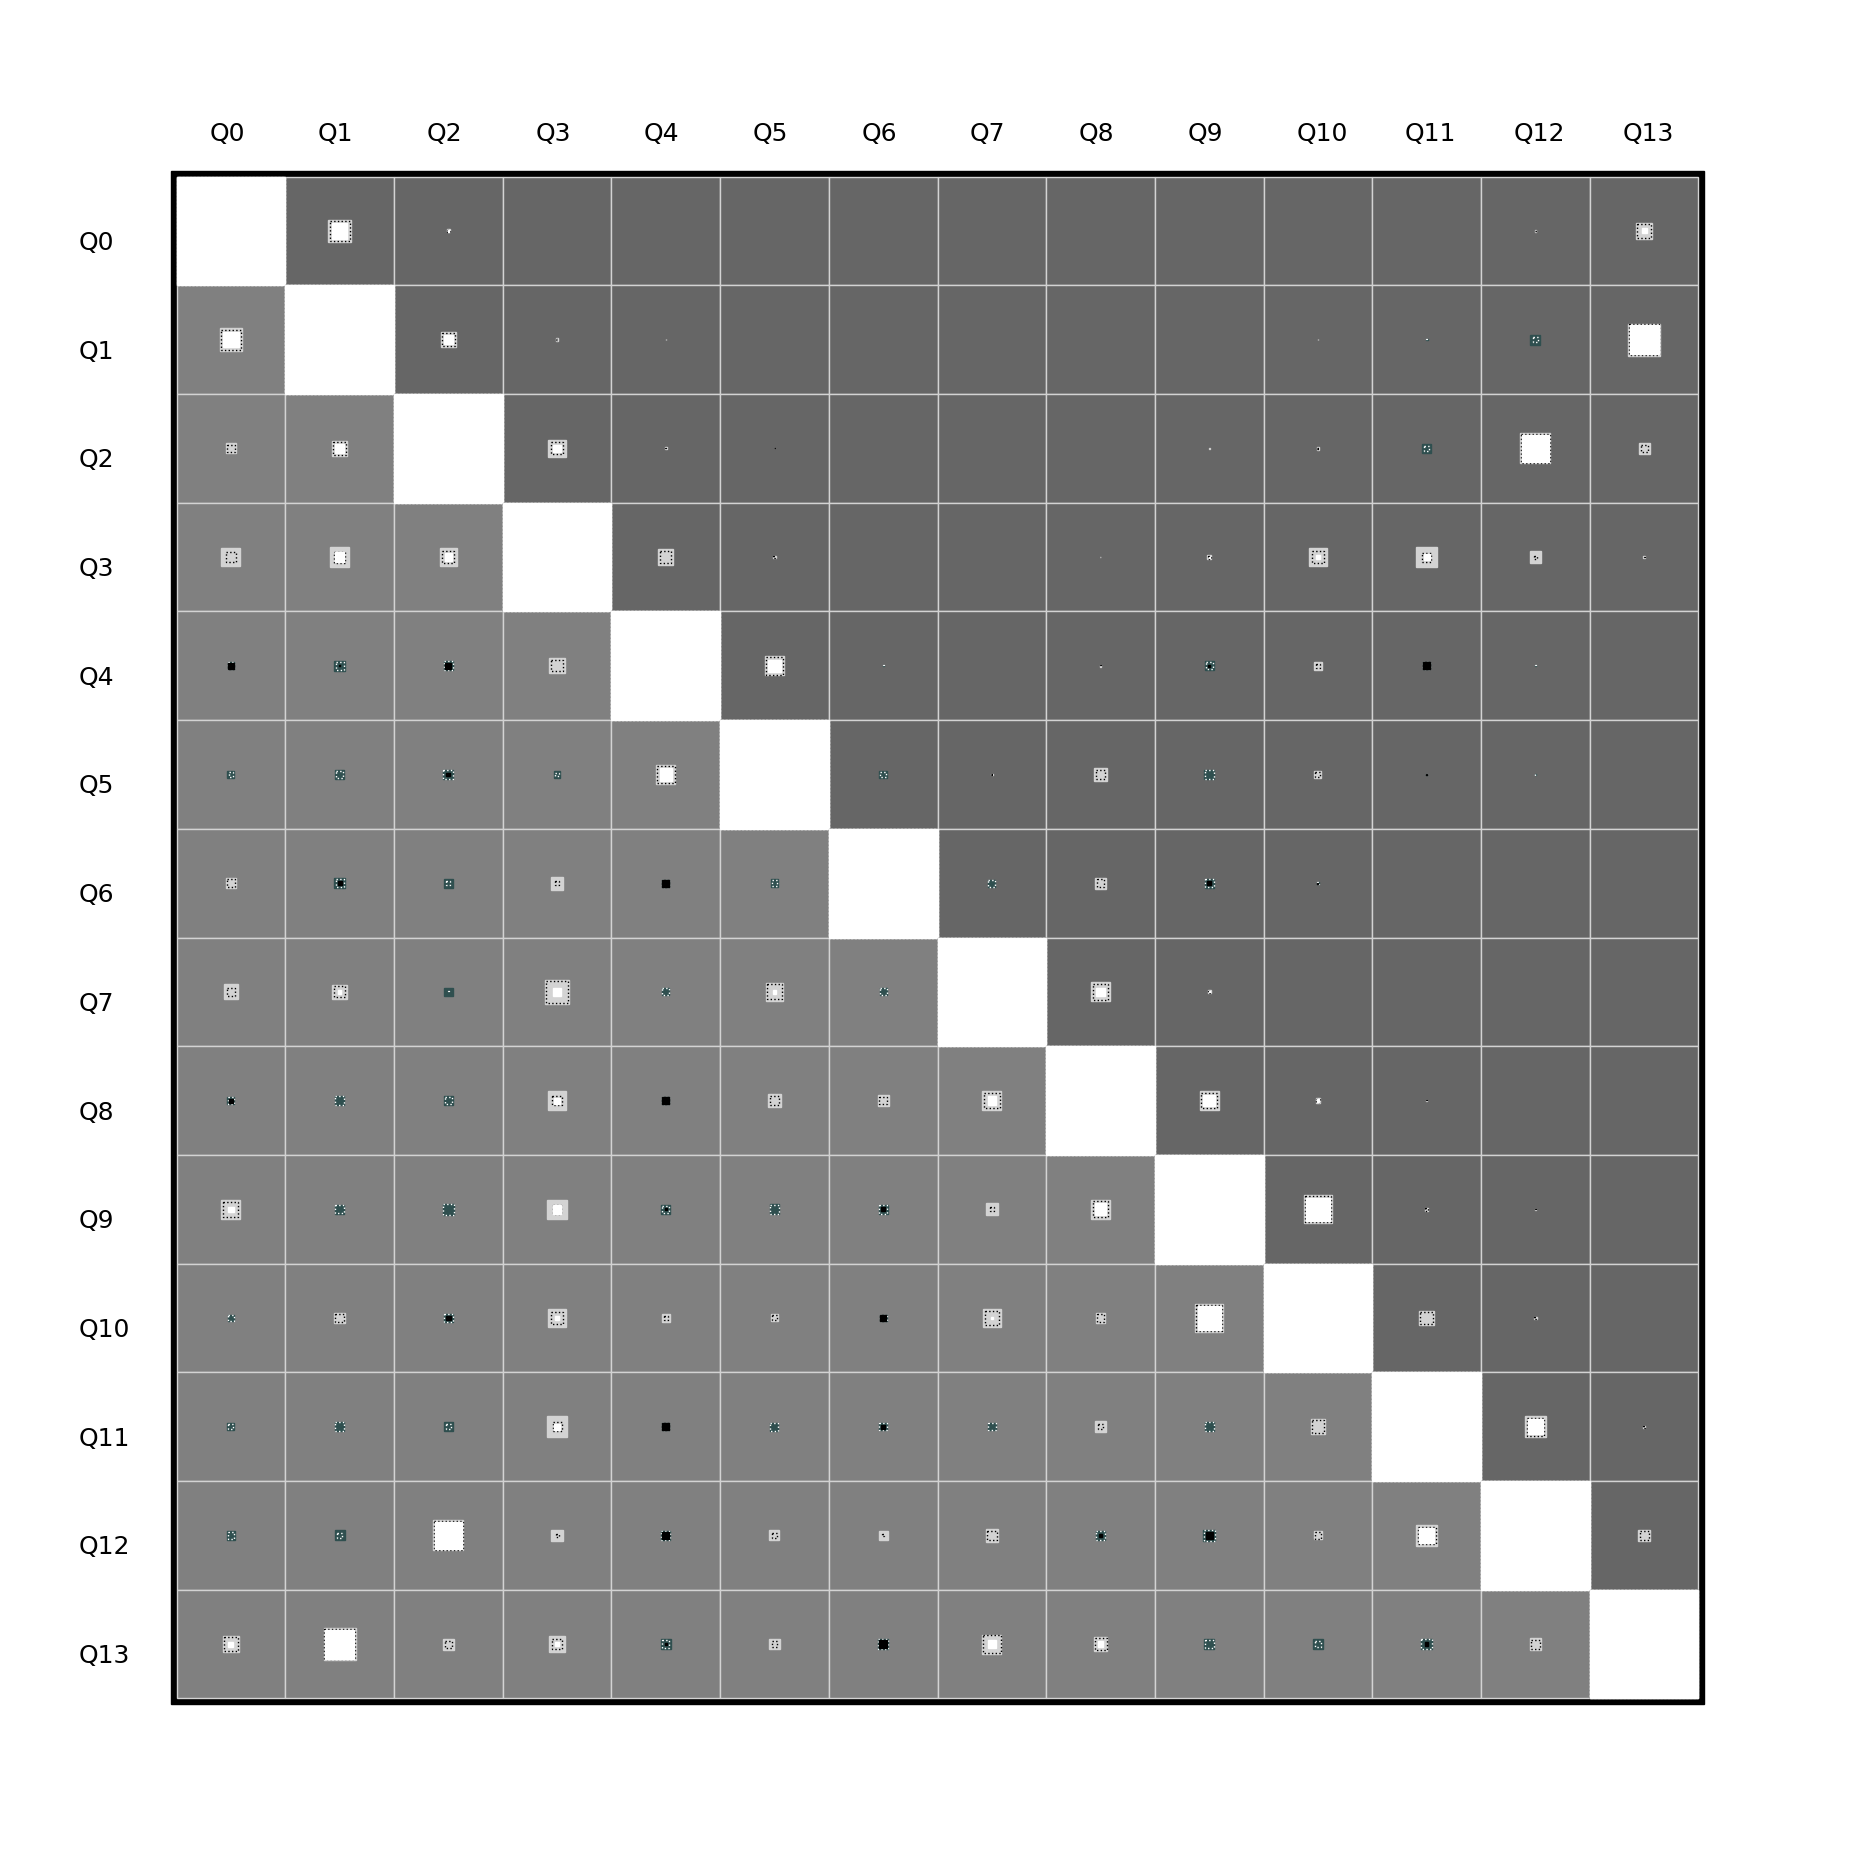

In [34]:
fig = figure("Slightly larger",figsize=(24,24))
covhinton(corrmatCombined,1,gca(),
    highCorr = corrmatCH,
    lowCorr =  corrmatCL,
    addScale=false,
    addAxis=true,
    adjust=0.8,
    voffset=0.6,
    addOneAxis=true,
    showQubits=false,
    fontsize=18,
    stagger=false,
    altColor="#666666")


#PyPlot.savefig("./SavedPDFs/combinedSingleAndGibbs.pdf", bbox_inches = "tight", pad_inches = 0)



### Seeing how good the fidelities are


In [35]:

for i = 1:14
    print("$i -> $(singleParams[2^(i-1)][2])\n")
end

1 -> 0.9932324762128337
2 -> 0.958705789506615
3 -> 0.9764096301614164
4 -> 0.9914470144273135
5 -> 0.9915582760133966
6 -> 0.9888915877220735
7 -> 0.9923471657027396
8 -> 0.993221207449483
9 -> 0.9898335914575224
10 -> 0.9808116162260787
11 -> 0.9920567042661474
12 -> 0.990604698583041
13 -> 0.9735830406430029
14 -> 0.9658785268210975


# Reconstruct the GRF by maginalising at the data results level



- Figure 5 (Supplement)



We take shortcut but omitting an easily writeable (if tedious) step. 

Recall we have our raw observation matrices for each of the RB lengths, stored in $2^14$ vectors, because this is quite a well behaved machine they are sparse. However if we really had $n$=50 qubits, then we couldn't store these vectors. We don't need to store it, read on:

The algorithm I'm going to call works as follows:

It uses the constraints for the Gibbs Random Field, to work out that what I need is, say, the joint probability distribution of qubits 1,2,3 and 4. To get them it marginalises the raw data probabilities (so the 2^4 set of numbers that represent the measurement outcome probabilities for these qubits, irrespective of the outcomes of the others). Now I lazily just pass in the $2^14$ vector and then call marginilise on it.

If I couldn't do that (n=50), I would have to read in each of the measurement strings, extract the relevant qubits from each bitstring and then create the 2^4 set of probabilities. That is an easy (if fidly) programming exercise that just requires you storing a large number of 50bit bitstring (for n=50). To make it as efficient as possible might be fun, but I'm not going to do it until I need to.

So assuming we marginalised our input data we then then worke out the joint probabilities we want.

It goes like this:

1) marginalised the input data. 
2) transform with Hadamard.
3) fit, extract the fit parameter.
4) transform back and project (just like before) 

except we are now dealing with really small probabilitiy vectors (2^3, 2^4 etc). The actual size of the probability vectors will depend on the bounded degree of the GRF in question.

This allows us to fill in the values of our gibbs field approximation. And efficiently we are done.

I'll show the few lines of code needed.

## Reconstruct from marginalising data

- Checks JSD

In [36]:
gibbsϕ2 = marginaliseFromRawData(splitMatrixS,constraints,singleLengths)

7-element Array{Array{Float64,1},1}:
 [0.9969056337065269, 0.0030943662934731623, 0.9871215787244313, 0.012878421275568715, 0.9942102507554922, 0.005789749244507765, 0.9651459746084651, 0.03485402539153497]                                                                                                                                                                               
 [0.9650034423996173, 0.018354888952621325, 0.014873131118649248, 0.0017685375291121123, 0.9613290439478254, 0.006658028370885121, 0.016120058327629784, 0.015892869353659744, 0.9369194071893806, 0.039642977785522476, 0.006860468057440788, 0.016577146967656102, 0.7790250645396003, 0.06847885911480311, 0.10723277611411847, 0.045263300231478086]
 [0.9764193865156825, 0.011629238272105146, 0.010724787274249987, 0.0012265879379623566, 0.963282306063897, 0.018287672532727915, 0.01357182266250538, 0.004858198740869679, 0.9315536661928158, 0.0684463338071842, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]                               

In [37]:
# For the sake of display!
for i in gibbsϕ2
    display(i)
end

8-element Array{Float64,1}:
 0.9969056337065269   
 0.0030943662934731623
 0.9871215787244313   
 0.012878421275568715 
 0.9942102507554922   
 0.005789749244507765 
 0.9651459746084651   
 0.03485402539153497  

16-element Array{Float64,1}:
 0.9650034423996173   
 0.018354888952621325 
 0.014873131118649248 
 0.0017685375291121123
 0.9613290439478254   
 0.006658028370885121 
 0.016120058327629784 
 0.015892869353659744 
 0.9369194071893806   
 0.039642977785522476 
 0.006860468057440788 
 0.016577146967656102 
 0.7790250645396003   
 0.06847885911480311  
 0.10723277611411847  
 0.045263300231478086 

16-element Array{Float64,1}:
 0.9764193865156825   
 0.011629238272105146 
 0.010724787274249987 
 0.0012265879379623566
 0.963282306063897    
 0.018287672532727915 
 0.01357182266250538  
 0.004858198740869679 
 0.9315536661928158   
 0.0684463338071842   
 0.0                  
 0.0                  
 0.0                  
 1.0                  
 0.0                  
 0.0                  

16-element Array{Float64,1}:
 0.9910095907111011  
 0.004175377401851234
 0.004815031887047652
 0.0                 
 0.9726451713349487  
 0.027354828665051355
 0.0                 
 0.0                 
 1.0                 
 0.0                 
 0.0                 
 0.0                 
 0.84423619431116    
 0.15576380568883996 
 0.0                 
 0.0                 

16-element Array{Float64,1}:
 0.9922626542086238   
 0.004094336333679412 
 0.003643009457696706 
 0.0                  
 0.9695675540576739   
 0.030359475329636385 
 4.5655217996111806e-5
 2.731539469348455e-5 
 0.9734014625470084   
 0.0                  
 0.02659853745299158  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  

16-element Array{Float64,1}:
 0.9845556715632994  
 0.005584496210464828
 0.009859832226235746
 0.0                 
 0.9688785963205334  
 0.031121403679466635
 0.0                 
 0.0                 
 0.9734002062797921  
 0.005272340106207541
 0.021327453614000375
 0.0                 
 1.0                 
 0.0                 
 0.0                 
 0.0                 

8-element Array{Float64,1}:
 0.9878530490194113    
 0.003814456708074005  
 0.004899805503735459  
 2.7626467038544916e-5 
 0.0032610269136413663 
 0.0                   
 0.00014403538809935426
 0.0                   

In [38]:
# Lets check this out (because we can) blow it up to the full probability distribution
reconstructedPps2 = [getGrainedP(gibbsϕ2,tomatch,constraints) for tomatch=0:(2^14-1)]
@assert(isapprox(sum(reconstructedPps2),1))

In [39]:
# This is what we had with the 'full' GRF reconstruction
sqrt(JSD(singlePps,reconstructed))

0.04164373290220545

In [40]:
# This is what we had with the 'efficient' GRF construciton
sqrt(JSD(singlePps,reconstructedPps2))

0.046559903542257836

## Bootstrap this process

In [50]:
# Of course we now need error bars
# Warning takes 20~30 mins

# And adding error bars
# This takes a bit of storage and a bit of work
bootStrapReconstructedPPs = []
@showprogress for x in thousandSPps
    ϕ=gibbsRandomField(x,constraints) 
    # Reconstruct the entire probability distribution using our markov field.
    push!(bootStrapReconstructedPPs,[getGrainedP(ϕ,tomatch,constraints) for tomatch=0:(2^14-1)])
end


# This takes a bit of storage and a bit of work
_size = 2^14
shots = sum(fullMatrixS[1,:])
bootStrapReconstructedPPMs = []
culmMatrixX = map(cumsum,splitMatrixS)
# There is a bit more classical computation going on, but I have not made any attempt to optimise.
@showprogress for co in 1:1000
    bsm=bootStrappedMatrices(_size,shots,culmMatrixX)
    ϕM=marginaliseFromRawData(bsm,constraints,singleLengths)
    # Reconstruct the entire probability distribution using our markov field.
    push!(bootStrapReconstructedPPMs,[getGrainedP(ϕM,tomatch,constraints) for tomatch=0:(2^14-1)])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:51
Progress: 100%|█████████████████████████████████████████| Time: 0:20:47


## Get error bars on JSD

In [51]:
# Error bars - marginal obs to GRF
extractEnds(sqrt.(sort([JSD(singlePps,x) for x in bootStrapReconstructedPPMs])),low=27,high=977)
# Tighter probably because less wiggle room in the projection step to a smaller simplex

(0.045908939663445114, 0.048006302442197814)

## Create Correlation matrices

In [52]:
# Then the GRF from the marginalised observations
corrmatsSingleGibbsM = [correlationMatrix(x) for x in bootStrapReconstructedPPMs];
corrmatSingleGibbsM = correlationMatrix(reconstructedPps2);

# And extract the ends we are interested in.
highCorrSingleGibbsM = [extractEnds(sort(map(x->x[b,a],corrmatsSingleGibbsM)),low=159,high=841)[2] for a in 1:14, b in 1:14]
lowCorrSingleGibbsM =  [extractEnds(sort(map(x->x[b,a],corrmatsSingleGibbsM)),low=159,high=841)[1] for a in 1:14, b in 1:14];

In [53]:
# Moosh them together so one is in the top right and the other in the bottom left
corrmatCombined = copy(corrmatSingleGibbs)
corrmatCH = copy(highCorrSingleGibbs)
corrmatCL = copy(lowCorrSingleGibbs)
for j = 2:14
    for i = 1:j-1
        corrmatCombined[i,j] = corrmatSingleGibbsM[i,j]
        corrmatCH[i,j] = highCorrSingleGibbsM[i,j]
        corrmatCL[i,j] = lowCorrSingleGibbsM[i,j]
    end
end
    

## Generate Figure 5 (supplement)

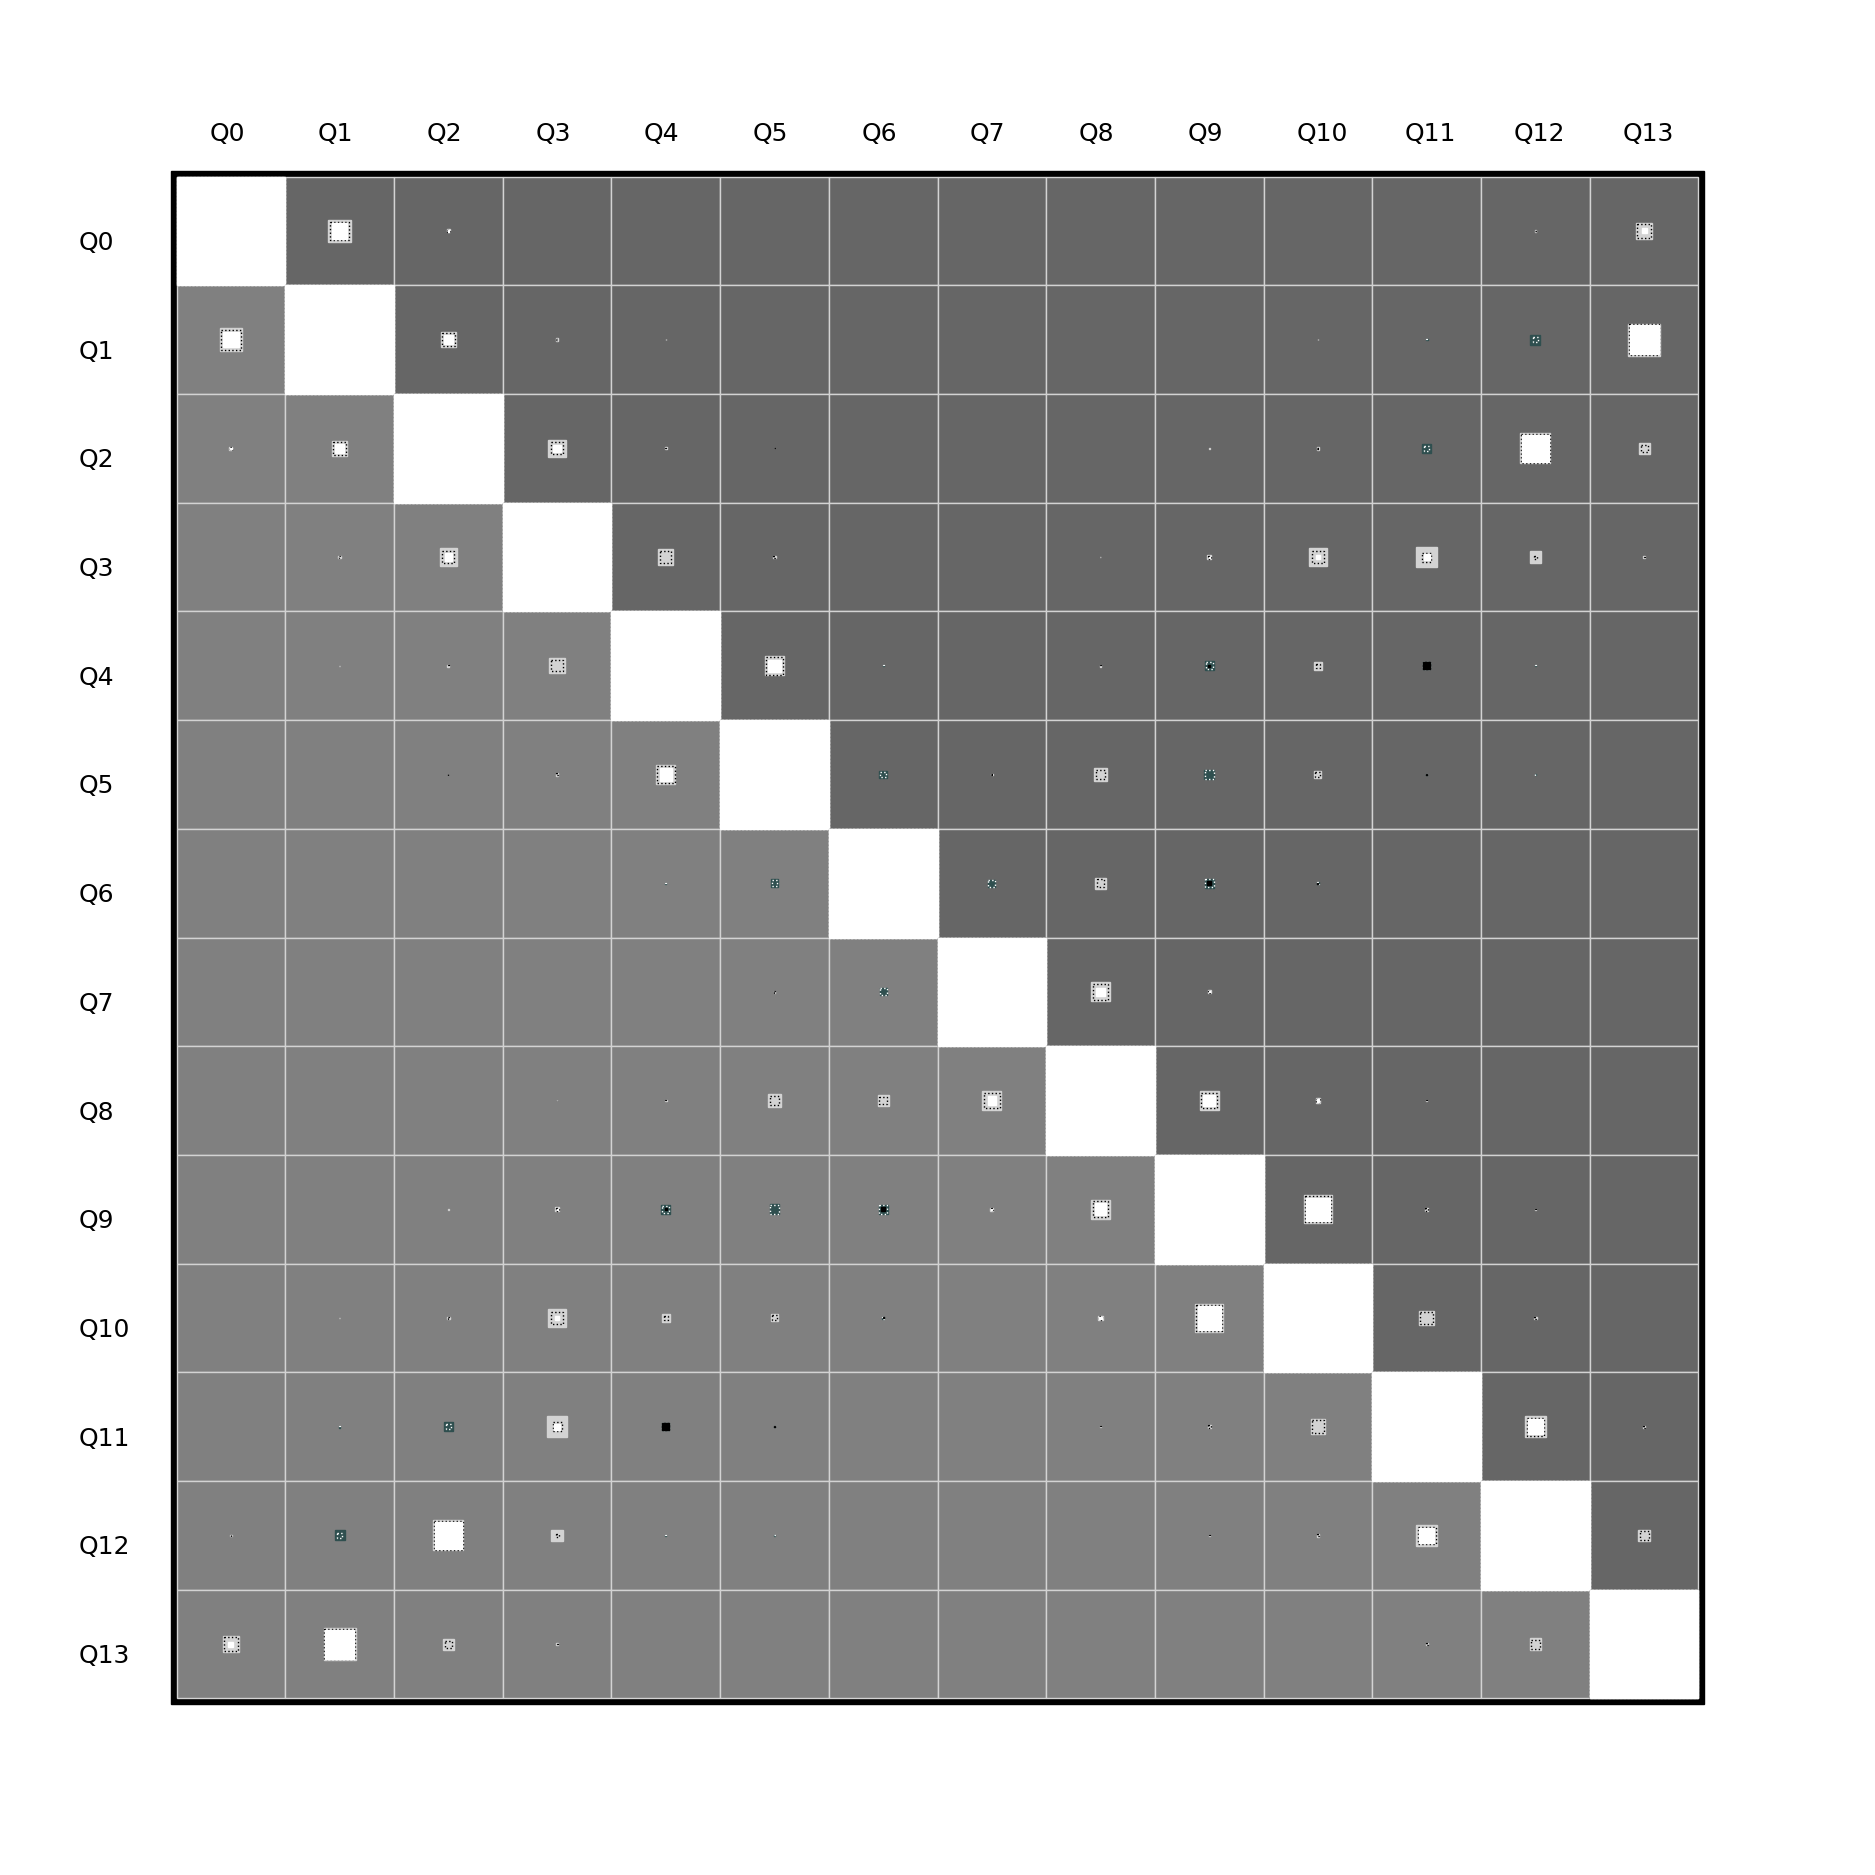

In [45]:
fig = figure("Slightly larger",figsize=(24,24))
covhinton(corrmatCombined,1,gca(),
    highCorr = corrmatCH,
    lowCorr =  corrmatCL,
    addScale=false,
    addAxis=true,
    adjust=0.8,
    voffset=0.6,
    addOneAxis=true,
    showQubits=false,
    fontsize=18,
    stagger=false,
    altColor="#666666")


#PyPlot.savefig("./SavedPDFs/efficientComparison.pdf", bbox_inches = "tight", pad_inches = 0)

# One of the referees asked about qubit 3 in particular, here we bar plot those correlations

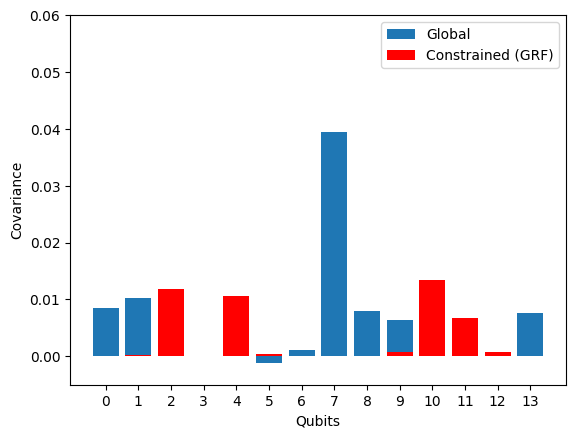

In [49]:
bar(0:13,map(x->x>0.9 ? 0 : x,corrmatSingle[4,:]),label="Global")
bar(0:13,map(x->x>0.9 ? 0 : x,correlationMatrix(reconstructed)[4,:]),color="red",label="Constrained (GRF)")
legend()
xticks(0:13);
xlabel("Qubits")
ylabel("Covariance")
ylim(-0.005,0.06)
#savefig("qubit3_singlequbitProtocol.pdf")

# Reconstruct the Covariance matrix using averaged Pauli error rates.



Single protocol version of Figure 4 (Supplement)

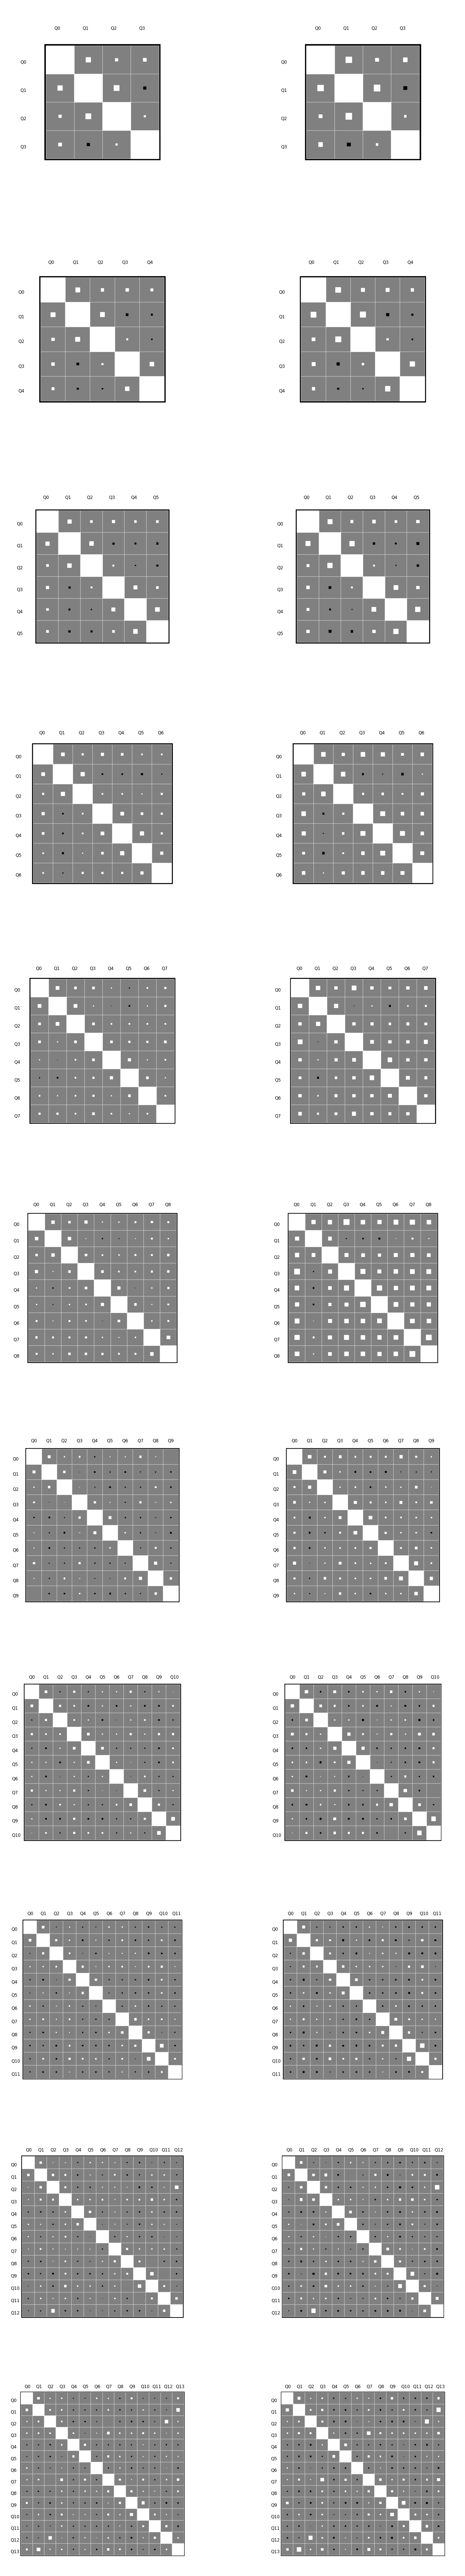

In [48]:
# These matrices are derived in the Supplement of the paper.

M = [1 0;0 1;0 1;0 1]
MI = [1 0 0 0;0 1 1 1]
actualN = MI*(0.25*[1 1;1 -1]⊗[1 1;1 -1])*M

fig = figure("Slightly larger",figsize=(24,130))

# Check for various sizes of data.
for q = 4:14

sM1_4=[marginalise(1:q,m) for m in splitMatrixS];   
newEigs = vcat([1],map(x->x[2],fitTheFidelities(singleLengths,sM1_4)[1]))
# Get the 'corrected' eigenvalues.
newEigs = ifwht_natural(projectSimplex(fwht_natural(newEigs)))

# p4 represents the 'Observed error rates'
p4 =  projectSimplex(fwht_natural(newEigs))
# xp4 re
xp4 = projectSimplex(foldl(⊗,[actualN for _=1:q])*newEigs)

corrmat1= correlationMatrix(p4);
corrmat2= correlationMatrix(xp4);



subplot(11,2,(q-4)*2+1)
ax=gca()
covhinton(corrmat1,1,ax,
            addAxis=true,adjust=0.8,addOneAxis=true,
            stagger=false,voffset=0.4)

subplot(11,2,(q-4)*2+2)
ax=gca()
covhinton(corrmat2,1,ax,
            addAxis=true,adjust=0.8,addOneAxis=true,
            stagger=false,voffset=0.4)
end
#fig 